<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Pytorch-Tutorial-001" data-toc-modified-id="Pytorch-Tutorial-001-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Pytorch Tutorial 001</a></span><ul class="toc-item"><li><span><a href="#Defining-a-simple-convolutional-neural-network" data-toc-modified-id="Defining-a-simple-convolutional-neural-network-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Defining a simple convolutional neural network</a></span></li><li><span><a href="#Configuring-the-network-training-parameters" data-toc-modified-id="Configuring-the-network-training-parameters-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Configuring the network training parameters</a></span></li><li><span><a href="#Loading-the-datasets-using-pytorch-dataloaders" data-toc-modified-id="Loading-the-datasets-using-pytorch-dataloaders-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Loading the datasets using pytorch dataloaders</a></span></li><li><span><a href="#Setting-up-the-Optimizer-to-optimize-the-loss-function" data-toc-modified-id="Setting-up-the-Optimizer-to-optimize-the-loss-function-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Setting up the Optimizer to optimize the loss function</a></span></li><li><span><a href="#Plotting-the-losses-and-Accuracy" data-toc-modified-id="Plotting-the-losses-and-Accuracy-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Plotting the losses and Accuracy</a></span></li></ul></li></ul></div>

# Pytorch Tutorial 001

Lets train a simple CNN on MNIST dataset. 


## Defining a simple convolutional neural network

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


## Configuring the network training parameters

The configuration to train the network are as below 

In [2]:
train_batch_size=64
test_batch_size=1000
epochs =30
lr=0.01
momentum = 0.5
no_cuda = False
seed = 1
log_interval = 1000
save_model = True

## Loading the datasets using pytorch dataloaders 

We use two loader for training set and test set. You can also use an optional validation set. 

In [3]:
from torchvision import datasets, transforms
use_cuda = False#not no_cuda and torch.cuda.is_available()
torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(datasets.MNIST('data', train=True, download=True,
                    transform=transforms.Compose([transforms.ToTensor(),
                                                  transforms.Normalize((0.1307,), (0.3081,))])),
                    batch_size=train_batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(datasets.MNIST('data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])),

batch_size=test_batch_size, shuffle=True, **kwargs)



Processing...
Done!


## Setting up the Optimizer to optimize the loss function

Using a simple stochastic gradient descent with nestrov's momentum 

In [4]:
from IPython.display import display, Math, Latex
display(Math(r'w:= w - \eta \sum_{i=1}^{n}\delta Q_{i}(w)/n'))

<IPython.core.display.Math object>

In [5]:
import torch.optim as optim
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [6]:
def train(model, device, train_loader, optimizer, epoch,log_interval):
    model.train()
    avg_loss = 0
    # in training loop:
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # zero the gradient buffers
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step() # Does the update
        avg_loss+=F.nll_loss(output, target, reduction='sum').item()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    avg_loss/=len(train_loader.dataset)
    return avg_loss

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss,accuracy

In [7]:
train_losses = []
test_losses = []
accuracy_list = []
for epoch in range(1, epochs + 1):
    trn_loss = train(model, device, train_loader, optimizer, epoch,log_interval)
    test_loss,accuracy = test(model, device, test_loader)
    train_losses.append(trn_loss)
    test_losses.append(test_loss)
    accuracy_list.append(accuracy)

if (save_model):
    torch.save(model.state_dict(),"mnist_cnn.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300039

Test set: Average loss: 0.1018, Accuracy: 9663/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.146140

Test set: Average loss: 0.0614, Accuracy: 9825/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.052315

Test set: Average loss: 0.0562, Accuracy: 9813/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.019015

Test set: Average loss: 0.0409, Accuracy: 9864/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.010967

Test set: Average loss: 0.0380, Accuracy: 9874/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.127716

Test set: Average loss: 0.0338, Accuracy: 9888/10000 (99%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.027539

Test set: Average loss: 0.0345, Accuracy: 9873/10000 (99%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.004211

Test set: Average loss: 0.0394, Accuracy: 9877/10000 (99%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.090090

Test set: Average loss: 0.0292, Accuracy: 9910/10000 (99%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.125310


## Plotting the losses and Accuracy

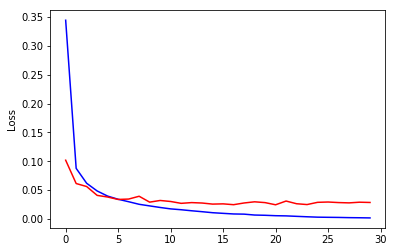

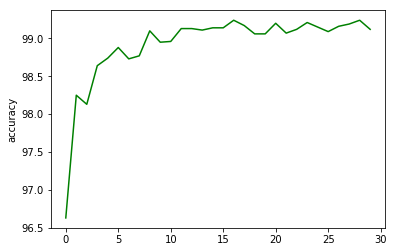

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_losses,'b')
plt.plot(test_losses,'r')
plt.ylabel('Loss')
plt.show()
plt.plot(accuracy_list,'g')
plt.ylabel('accuracy')
plt.show()